# Using Pyberlib

We made a library of matplotlib premade charts to use in future analysis.

We can build the library with:
```shell
python -m build
```
And install it with pip:
```shell
pip install ./dist/pyberlib-0.1.0-py3-none-any.whl
```
Or install in dev mode without building with:
```shell
python -m pip install -e .
```

In [1]:
# Load modules and dataframes
import pandas as pd
from pathlib import Path
from pyberlib import Pyber


resources = Path("resources")
output_path = Path("analysis") / "pyberlib"
city_data_df = pd.read_csv(resources / "city_data.csv")
ride_data_df = pd.read_csv(resources / "ride_data.csv")
pyber_data_df = city_data_df.merge(
    ride_data_df, on=["city", "city"]).set_index("city")
city_data_df = city_data_df.set_index("city")

## Creating Bubble Charts

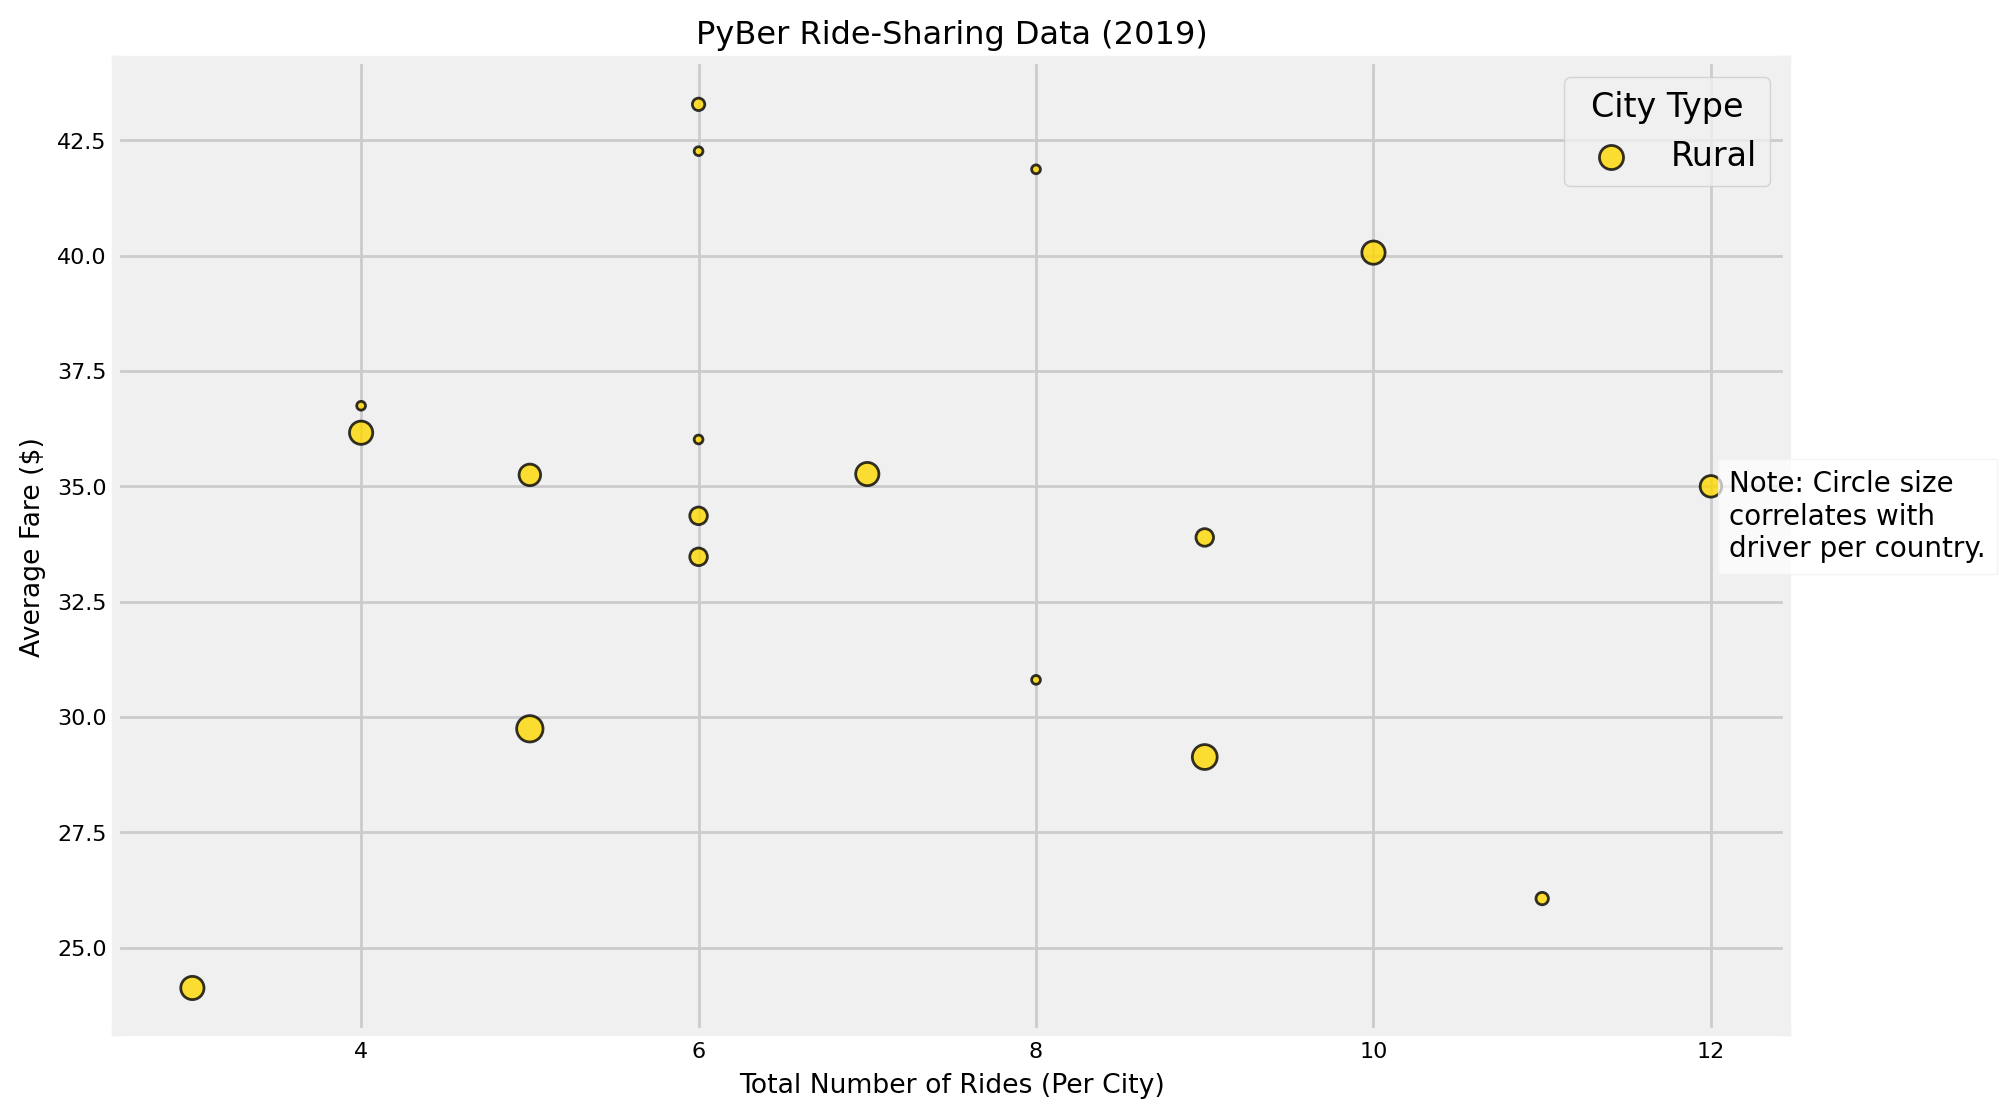

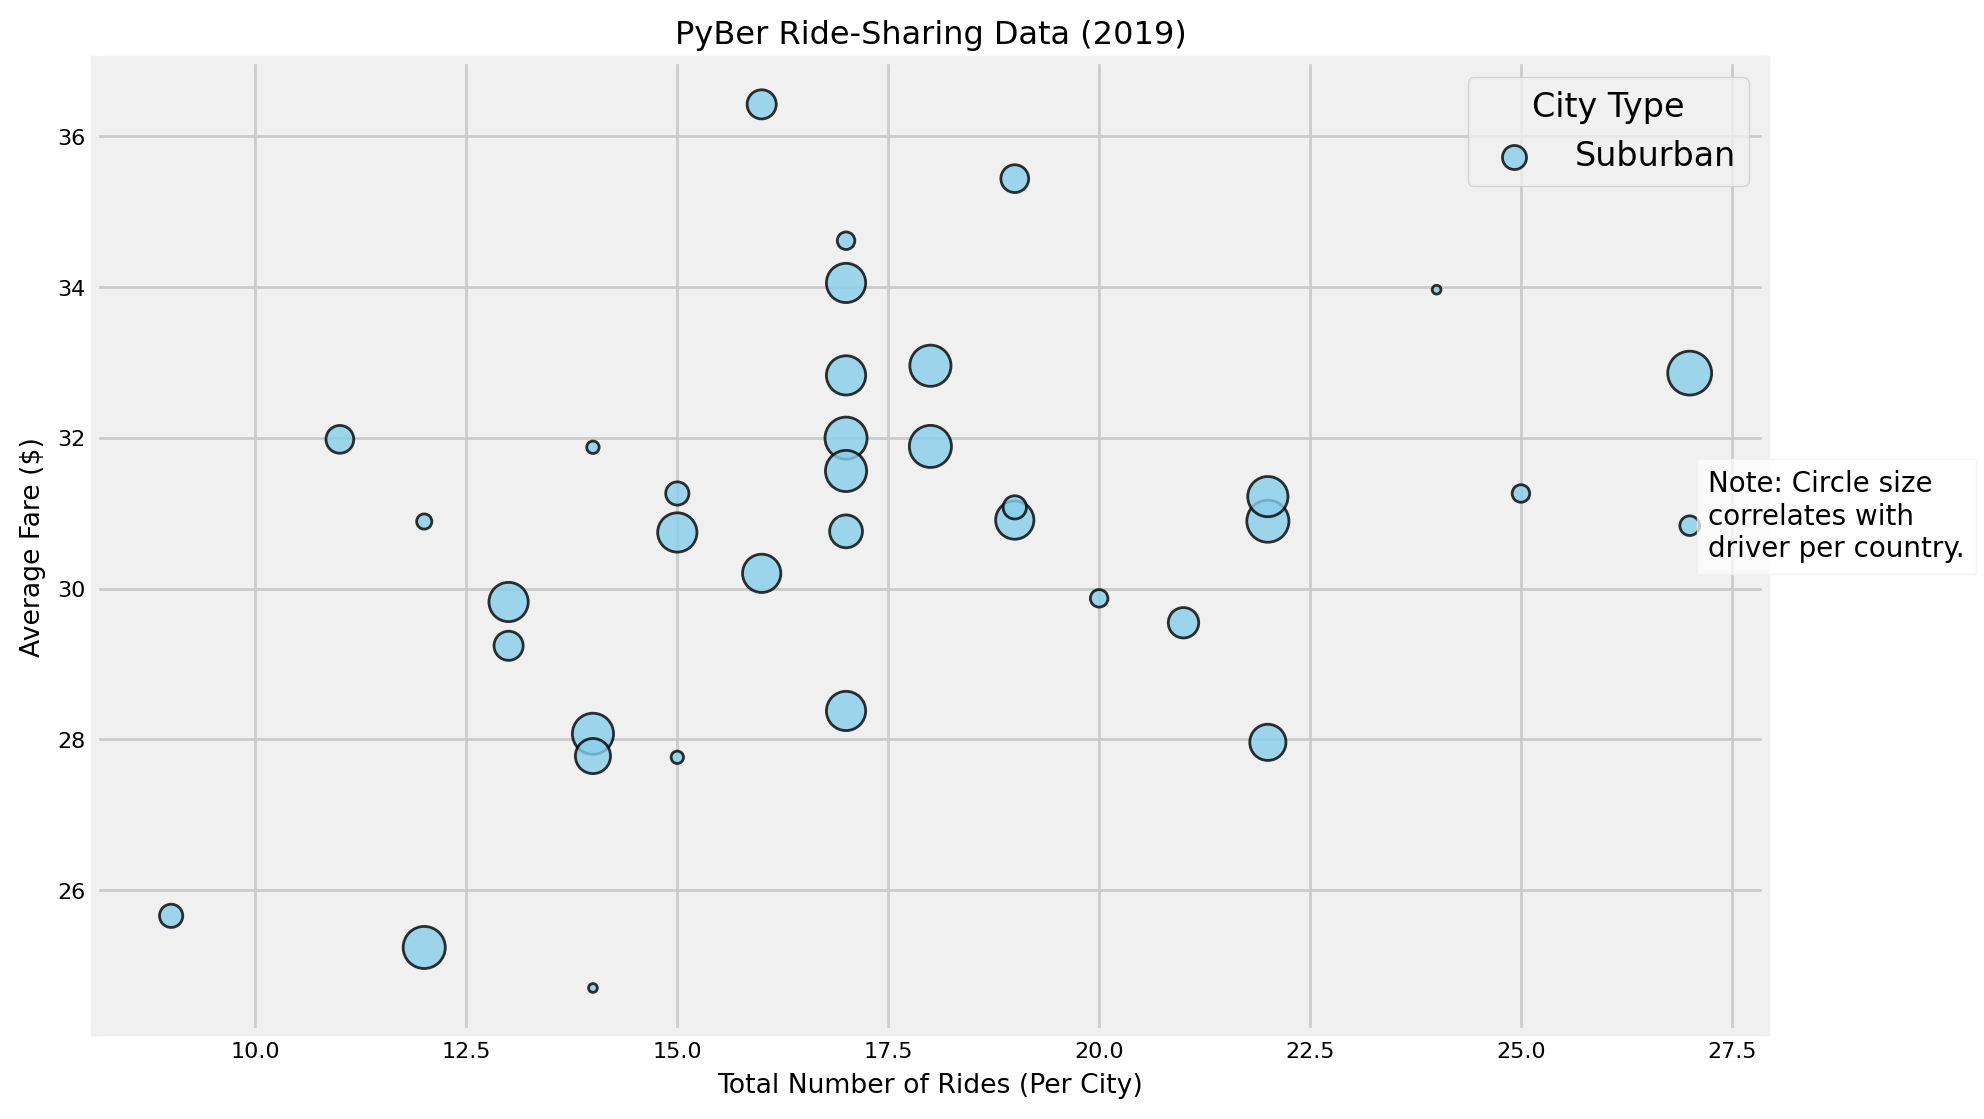

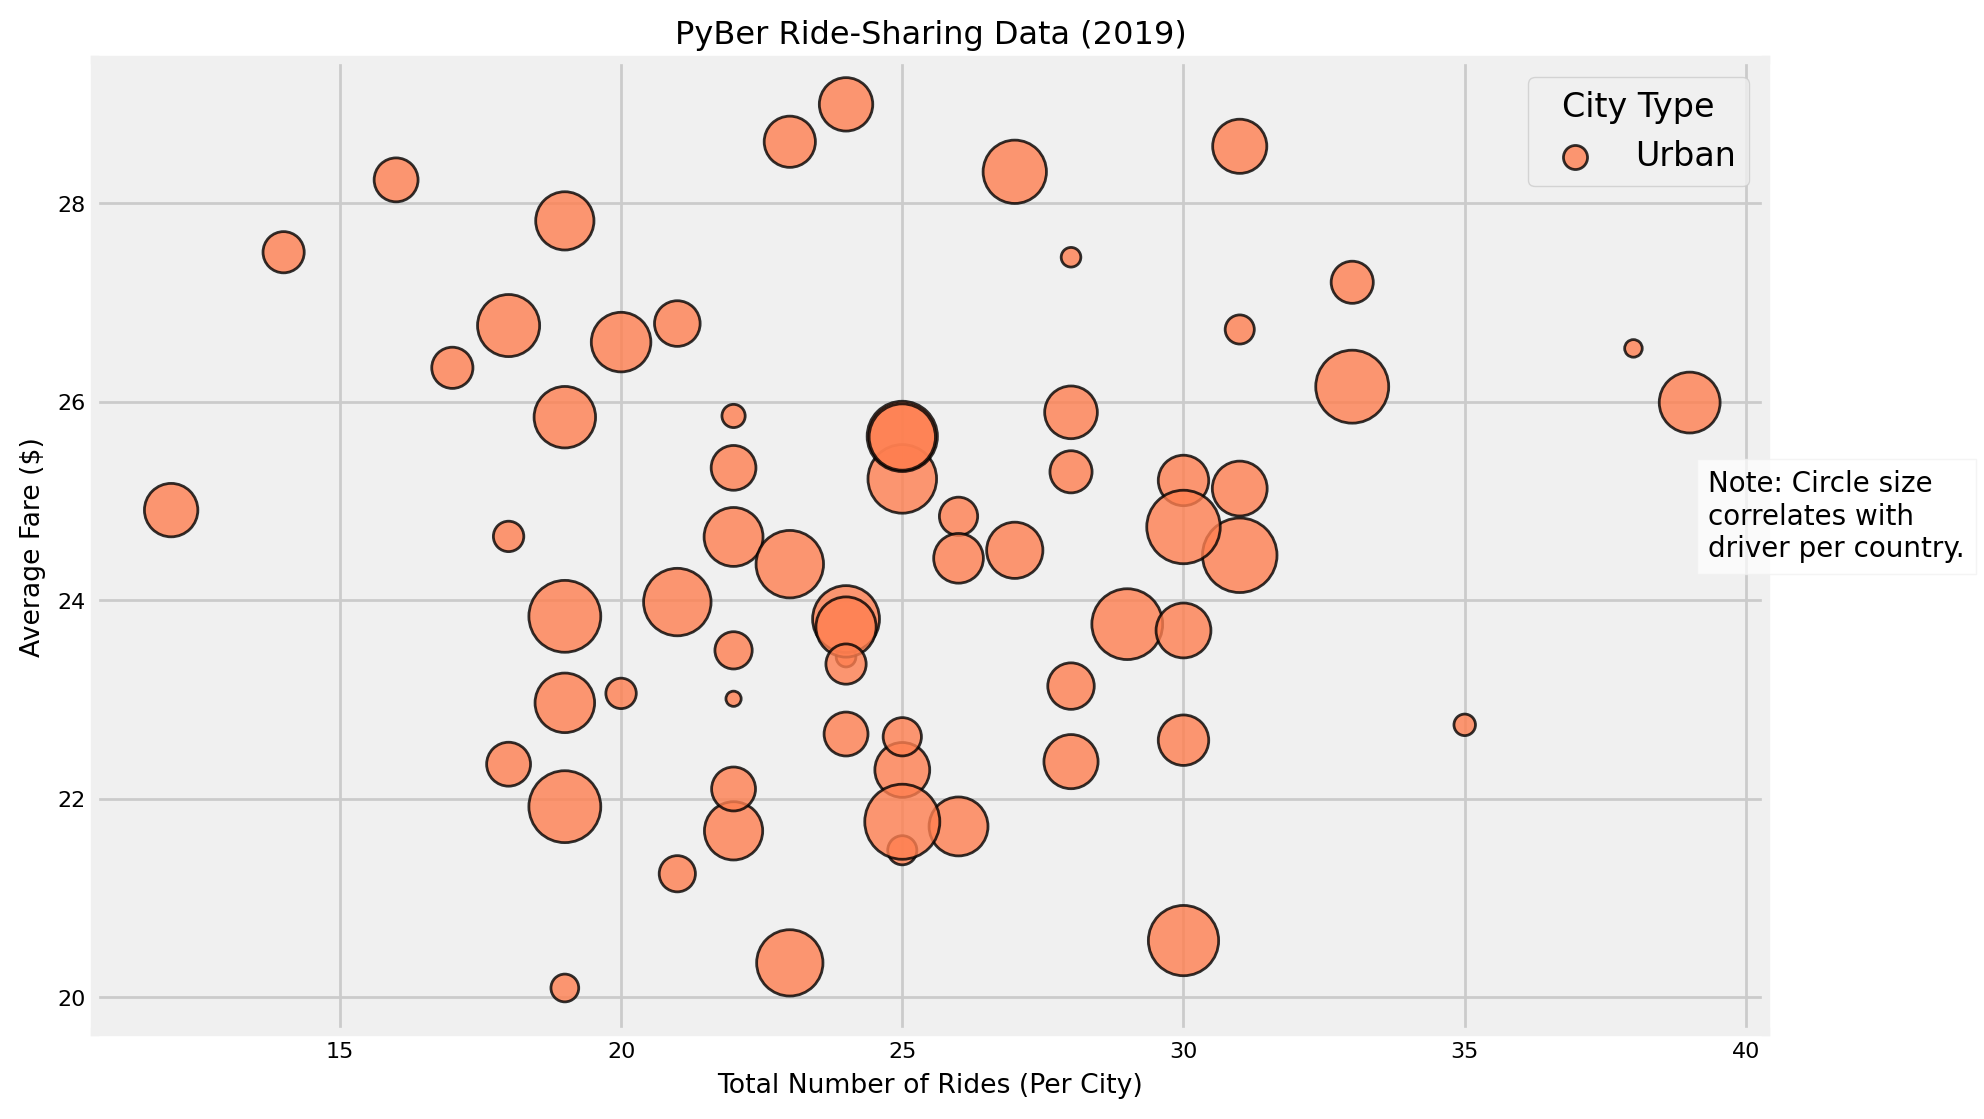

In [9]:
# Create Ride-sharing Data individual charts
average_fares_per_city_type = pyber_data_df.groupby(["type", "city"])["fare"].mean()
total_rides_per_city_type = pyber_data_df.groupby(["type", "city"])["ride_id"].count()
average_drivers_per_city_type = pyber_data_df.groupby(["type", "city"])["driver_count"].mean()
for fig, city_type in Pyber.plot_bubble_many(
    total_rides_per_city_type, 
    average_fares_per_city_type,
    average_drivers_per_city_type
):
    Pyber.savefig(fig, output_path / f"ridesharing_{city_type}.png")

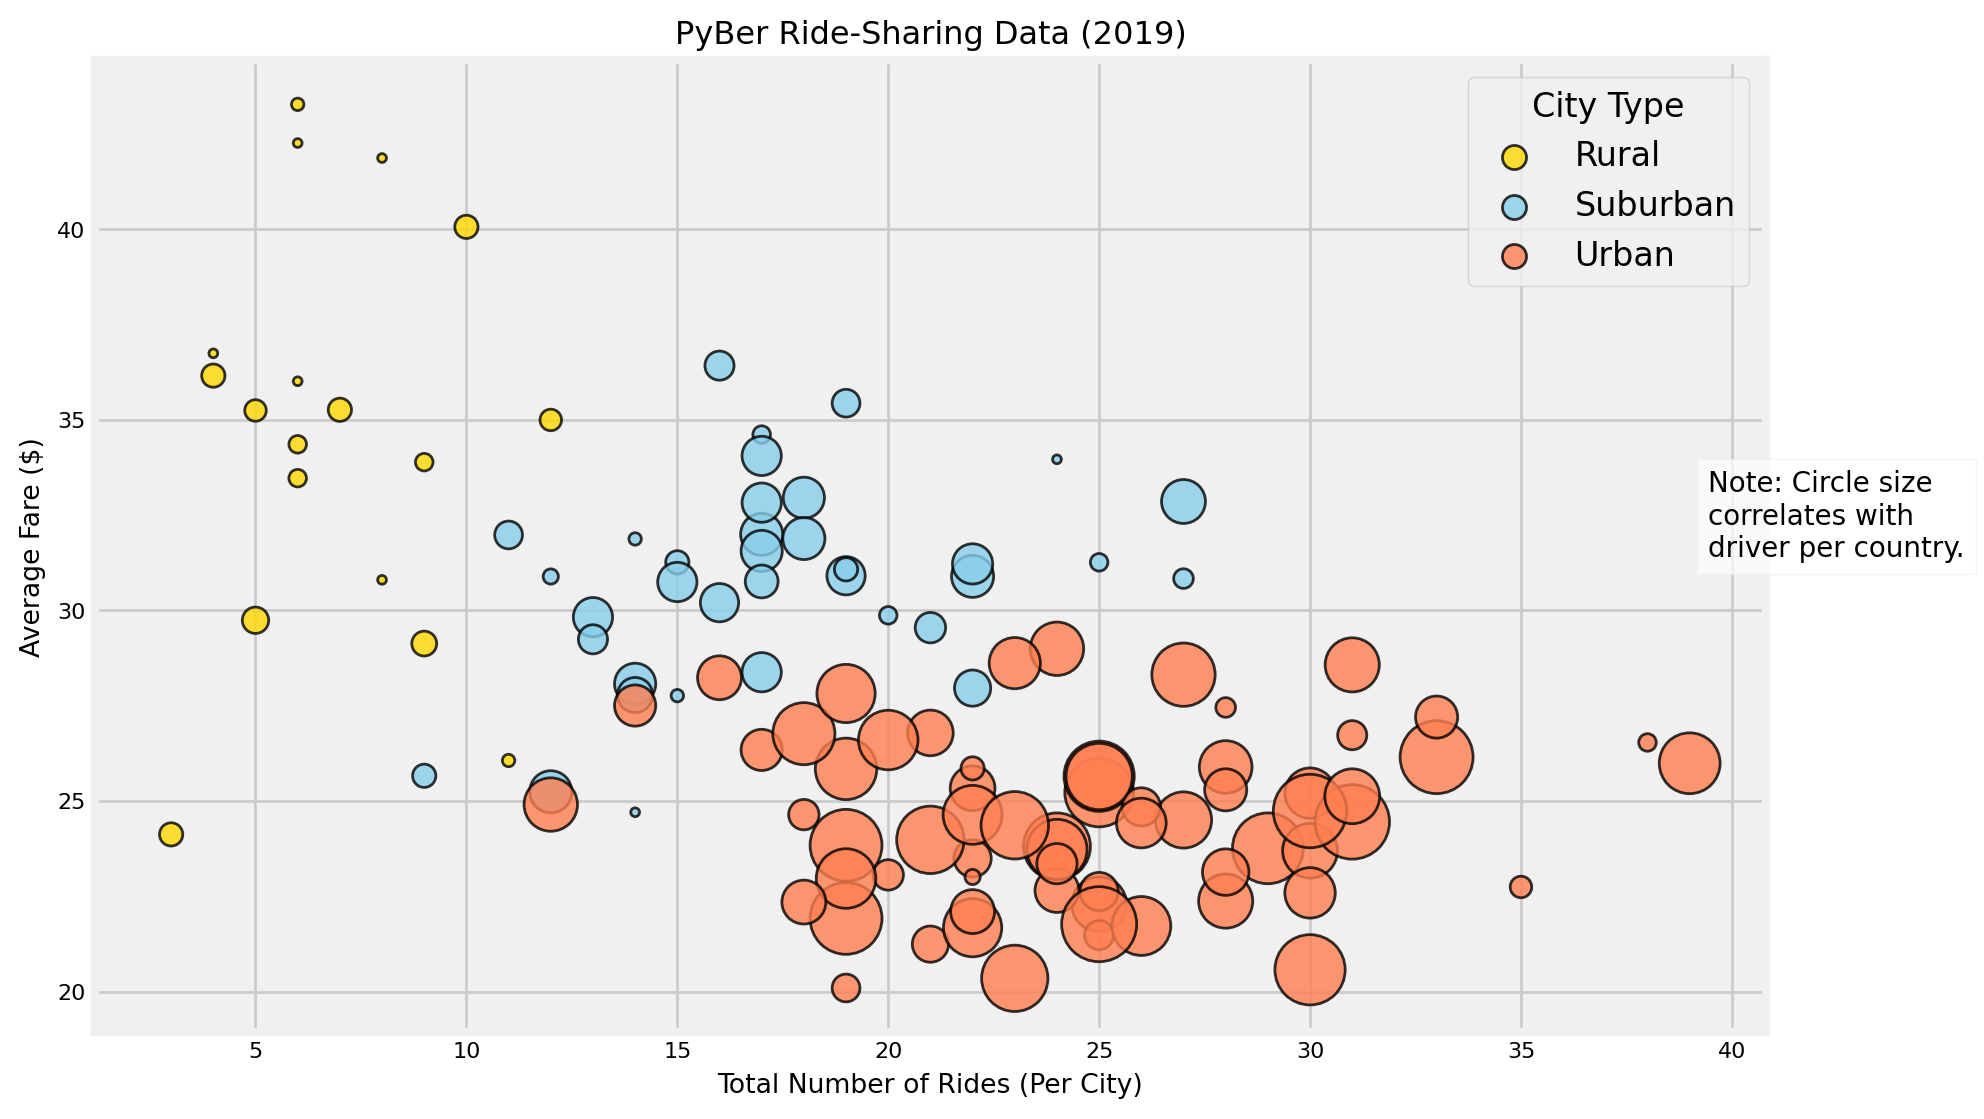

In [10]:
# Create combined Bubblechart
chart = Pyber.plot_bubble_combined(
    total_rides_per_city_type, 
    average_fares_per_city_type,
    average_drivers_per_city_type
)
Pyber.savefig(chart, output_path / "ridesharing_all.png")

## Creating Box and Whiskers

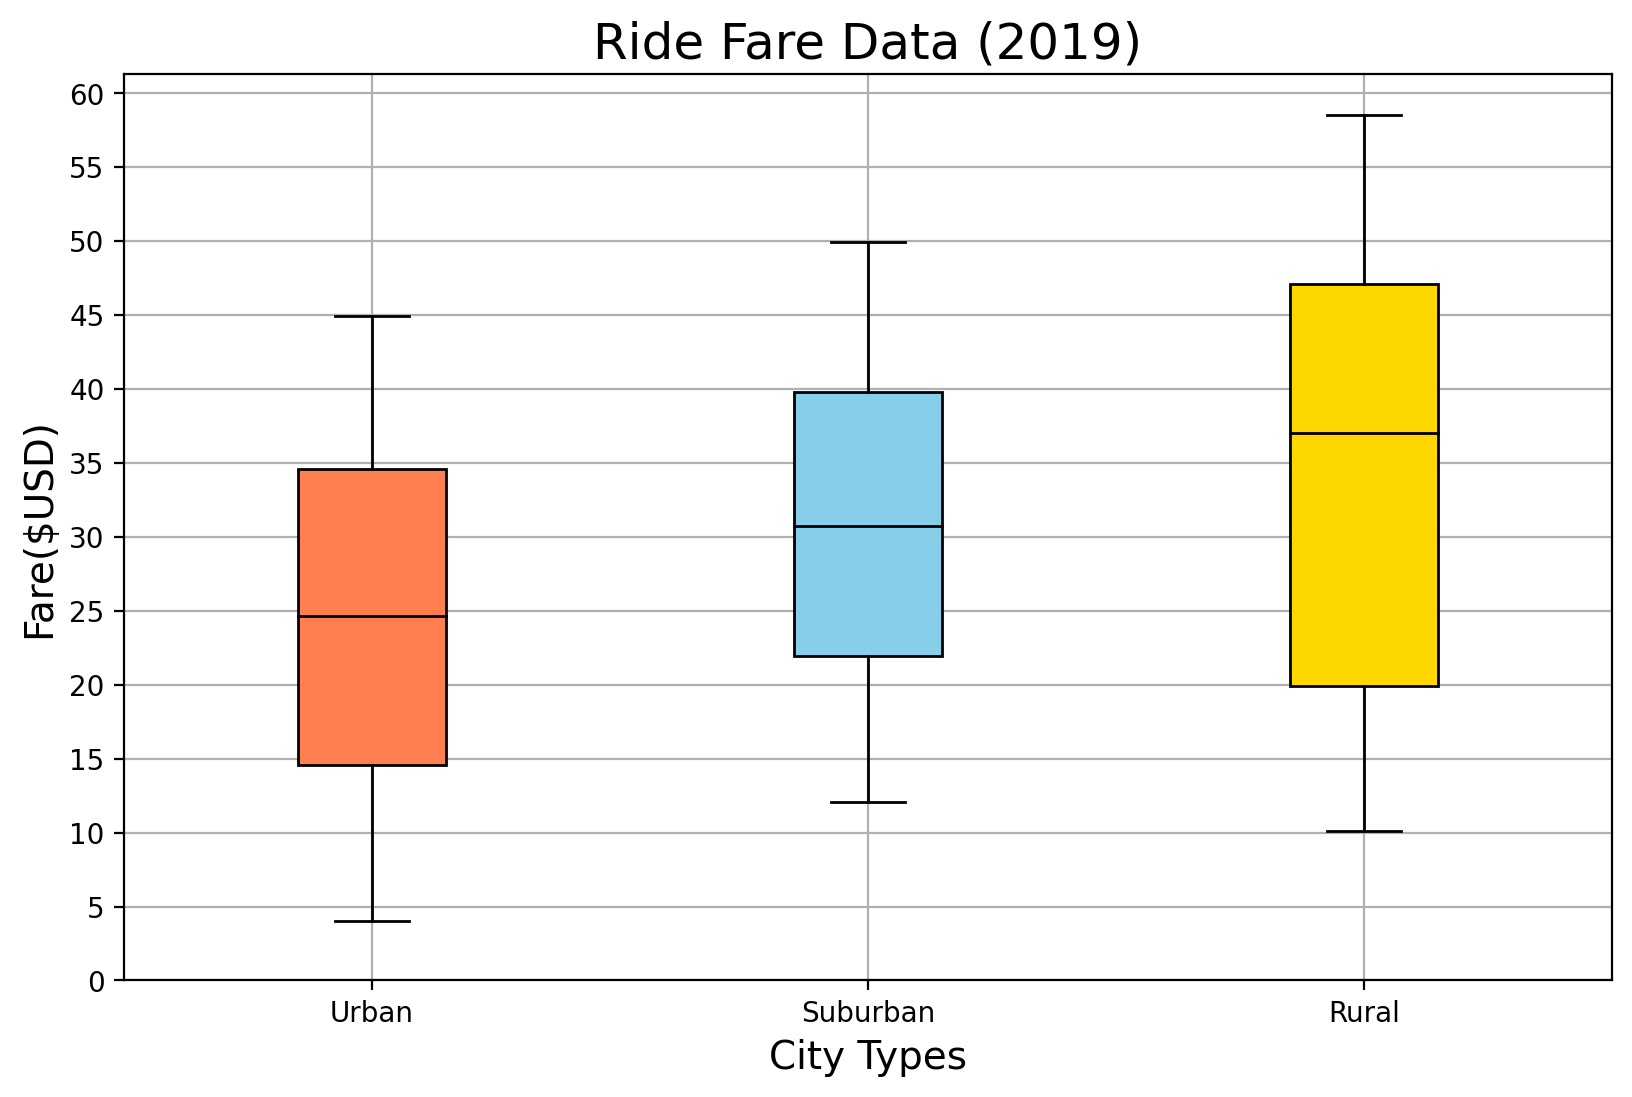

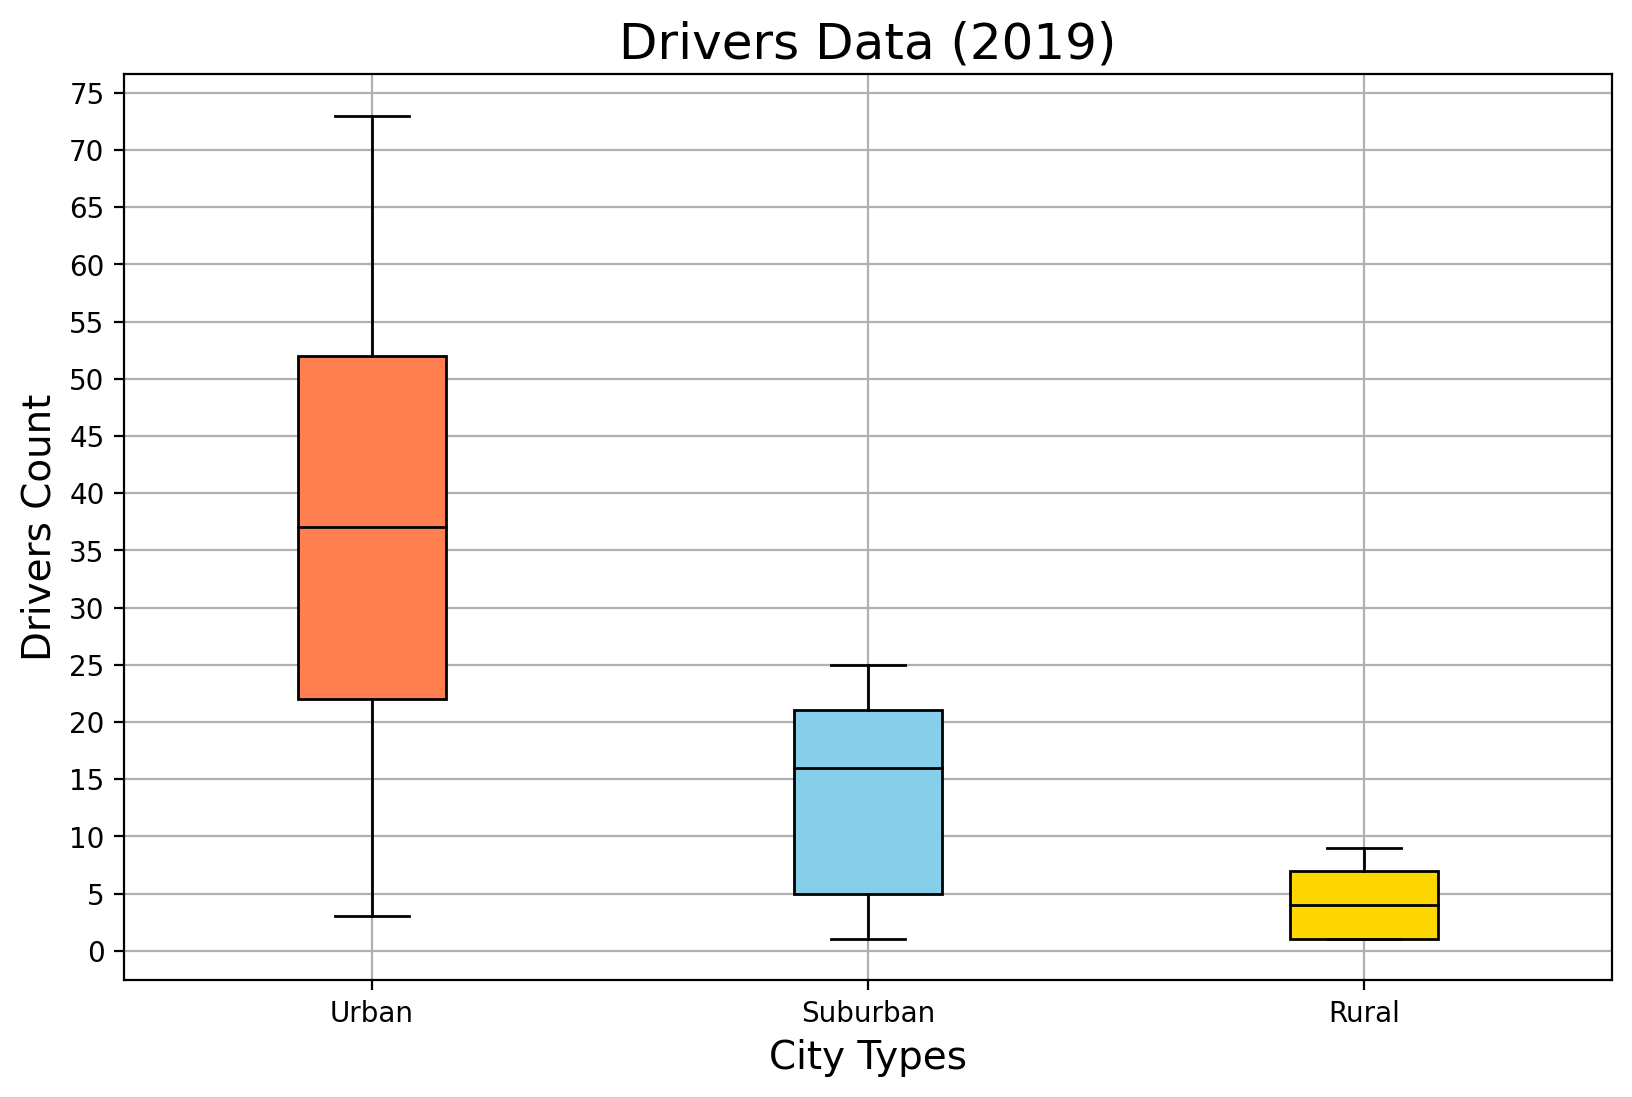

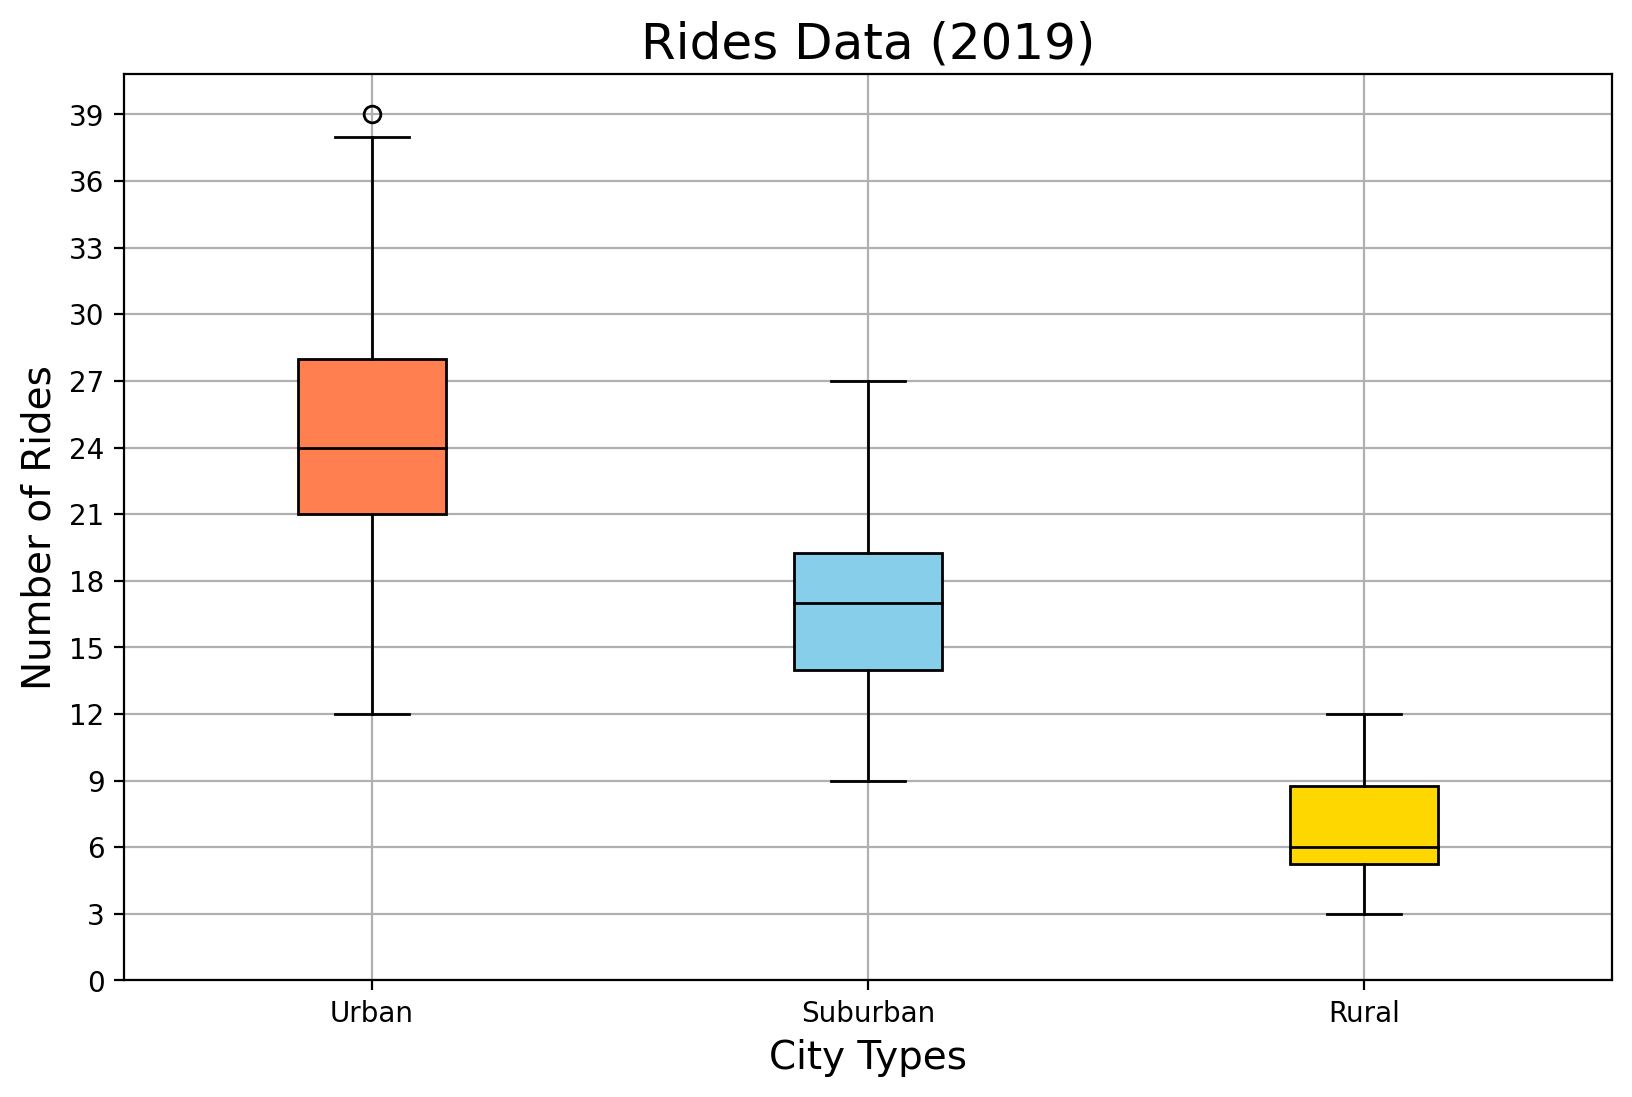

In [2]:
# Create Box and Whiskers
get_values_per_city_type = lambda column: pd.Series({
    city_type: pyber_data_df.loc[
    pyber_data_df["type"]==city_type, column].values
    for city_type in Pyber.city_types
})
# Fares
city_type_fares = get_values_per_city_type("fare")
fig = Pyber.plot_box_and_whiskers(
    city_type_fares, "Ride Fare Data (2019)", "Fare($USD)")
Pyber.savefig(fig, output_path/"citytype_fares.png")
# Driver Count
city_type_drivers = get_values_per_city_type("driver_count")
fig = Pyber.plot_box_and_whiskers(
    city_type_drivers, "Drivers Data (2019)", "Drivers Count")
Pyber.savefig(fig, output_path/"citytype_drivers.png")
# Ride Count Data
city_type_rides = pd.Series({
    city_type: pyber_data_df.loc[
    pyber_data_df["type"]==city_type, "ride_id"
    ].groupby("city").count()
    for city_type in Pyber.city_types
})
fig = Pyber.plot_box_and_whiskers(
    city_type_rides, "Rides Data (2019)", "Number of Rides")
Pyber.savefig(fig, output_path/"citytype_rides.png")

## Creating Pie Charts

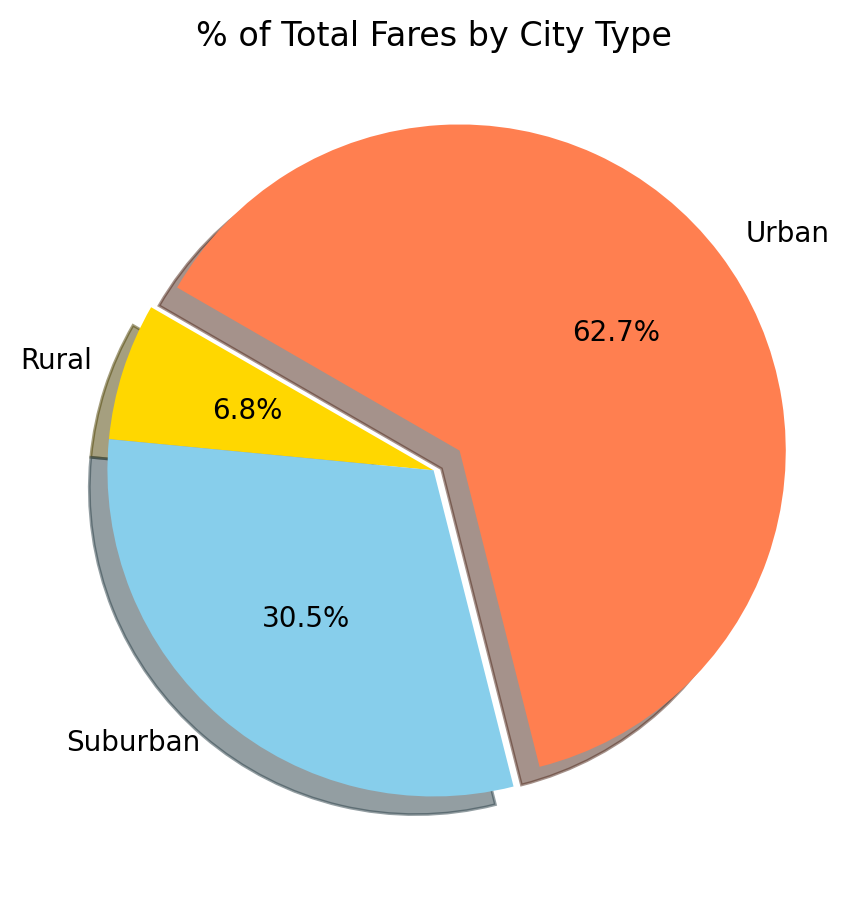

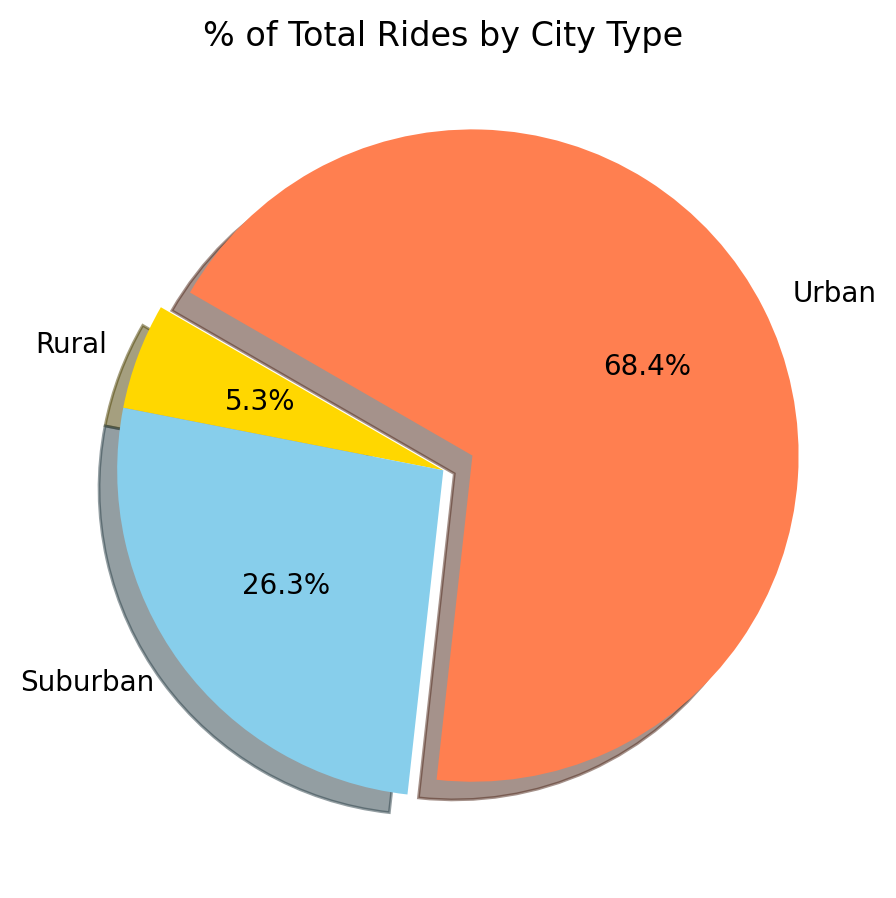

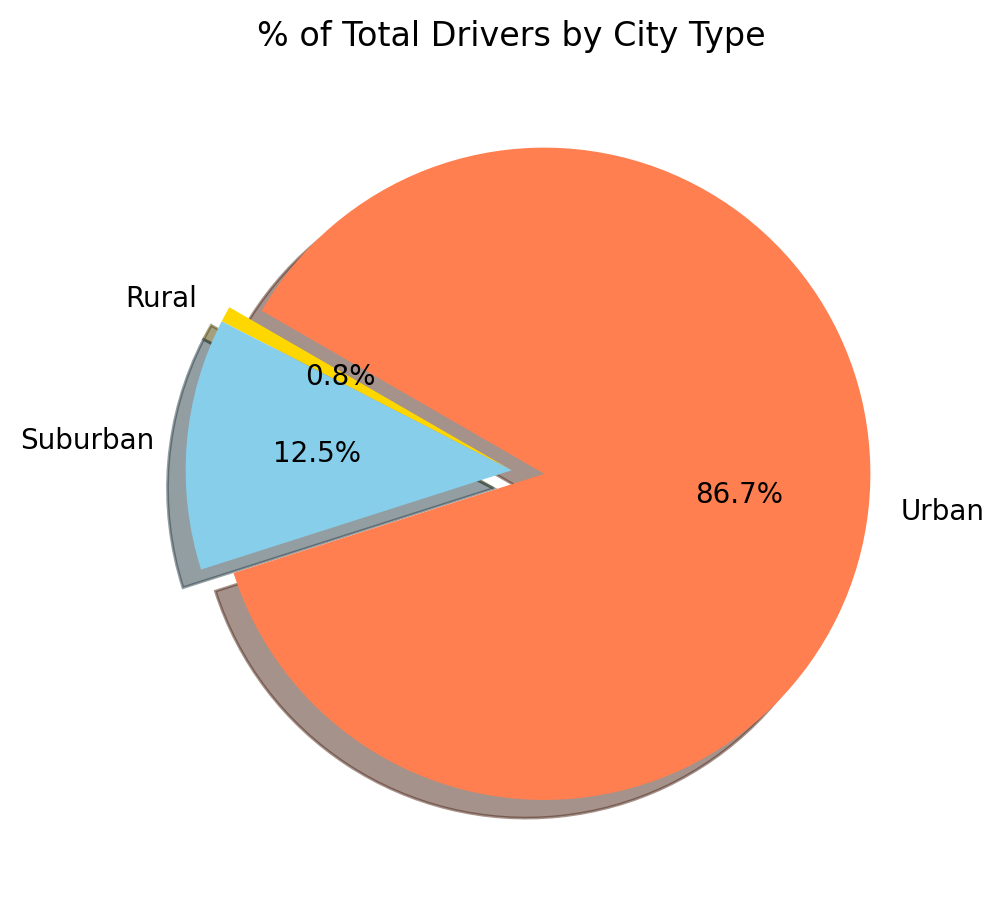

In [2]:
# Fares
percentage_fares = (
        100
        * pyber_data_df.groupby(["type"]).sum()["fare"]
        / pyber_data_df["fare"].sum()
    )
fig = Pyber.plot_pie_chart(percentage_fares, "% of Total Fares by City Type")
Pyber.savefig(fig, output_path/"percentage_fares.png")
# Ride Counts
percentage_rides = (
        100
        * pyber_data_df.groupby(["type"]).count()["ride_id"]
        / pyber_data_df["ride_id"].count()
    )
fig = Pyber.plot_pie_chart(percentage_rides, "% of Total Rides by City Type")
Pyber.savefig(fig, output_path/"percentage_rides.png")
# Drivers
percentage_drivers = (
        100
        * pyber_data_df.groupby(["type"]).sum()["driver_count"]
        / pyber_data_df["driver_count"].sum()
    )
fig = Pyber.plot_pie_chart(percentage_drivers, "% of Total Drivers by City Type")
Pyber.savefig(fig, output_path/"percentage_drivers.png")

## Creating Fares Summary

In [13]:
# Create fares summary
total_fares = pyber_data_df.groupby(["type"])["fare"].sum()
total_rides = pyber_data_df.groupby(["type"])["ride_id"].count()
total_drivers = city_data_df.groupby(["type"])["driver_count"].sum()
format_comma = lambda x: f"{x:,}"
format_currency = lambda x: f"${x:,.2f}"
fares_summary_df = pd.DataFrame(
    {
        "Total Rides":total_rides.map(format_comma),
        "Total Drivers":total_drivers.map(format_comma),
        "Total Fares":total_fares.map(format_currency),
        "Average Fare per Ride":(total_fares / total_rides).map(format_currency),
        "Average Fare per Driver":(total_fares / total_drivers).map(format_currency),
    }
)
fares_summary_df.index.name = ""
fares_summary_df.head()


,Total Rides,Total Drivers,Total Fares,Average Fare per Ride,Average Fare per Driver
,,,,,
Rural,125,78,"$4,327.93",$34.62,$55.49
Suburban,625,490,"$19,356.33",$30.97,$39.50
Urban,"1,625","2,405","$39,854.38",$24.53,$16.57


## Creating Time Series

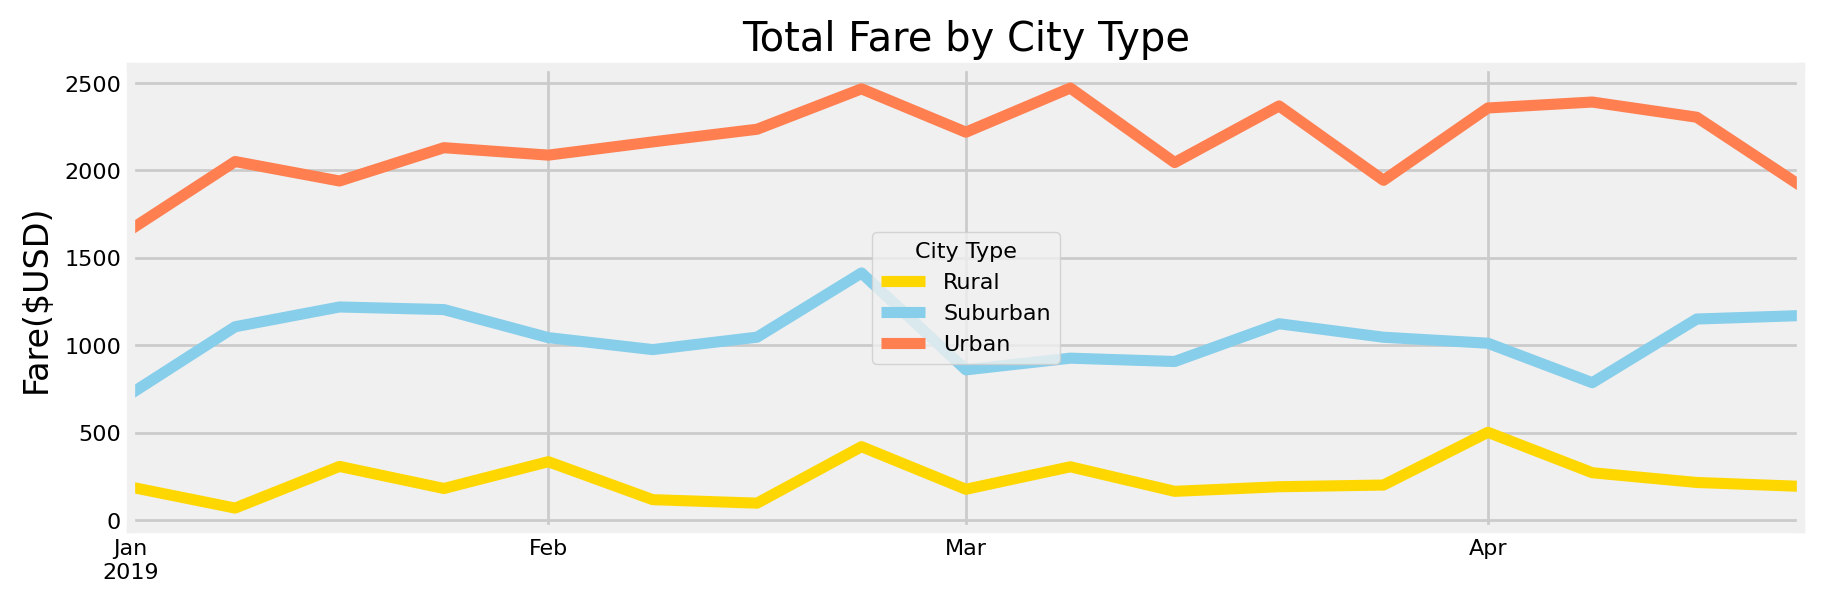

In [2]:
# Chart Total Fare Timeseries
dates = pyber_data_df.groupby(["type", "date"])["fare"].sum().reset_index()
dates_pivot = dates.pivot(index="date", columns ="type")
dates_range = dates_pivot.loc["2019-01-01":"2019-04-28"].reset_index()
dates_range["date"] = pd.to_datetime(dates_range["date"])
fares_per_week = dates_range.resample("W", on="date").sum()
# Chart
chart = Pyber.plot_timeseries(fares_per_week)
Pyber.savefig(chart, output_path / "PyBer_fare_summary.png")